In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import obspy
from obspy.clients.fdsn import Client
from scipy.signal import spectrogram
from obspy.signal.trigger import recursive_sta_lta, plot_trigger, trigger_onset

# Preprocessing Hawaii seismograms and creating spectrograms

## Preprocess seismograms

Filter chain
1. Remove instrument response
2. Highpass filter
3. Resample to 40 Hz if necessary
4. Normalize each trace
5. Pick P wave arrival
6. Trim trace

In [3]:
quakes = obspy.read("hawaii_2016-2018_mag3_POHA_waveforms.mseed", format="MSEED")

#Remove instrument response and high pass filter the waveforms
#client = Client("IRIS")
POHA = Client("IRIS").get_stations(network="IU", station="POHA", level='response')
quakes.remove_response(POHA)
quakes.filter('highpass', freq=1.0, corners=2, zerophase=True)

#downsample to make 

print(quakes)
quakes[0]

3201 Trace(s) in Stream:

IU.POHA.00.BHZ | 2018-12-30T00:58:15.894538Z - 2018-12-30T01:01:25.869538Z | 40.0 Hz, 7600 samples
...
(3199 other traces)
...
IU.POHA.00.BHZ | 2016-01-03T16:46:57.719536Z - 2016-01-03T16:50:07.669536Z | 20.0 Hz, 3800 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]


IU.POHA.00.BHZ | 2018-12-30T00:58:15.894538Z - 2018-12-30T01:01:25.869538Z | 40.0 Hz, 7600 samples

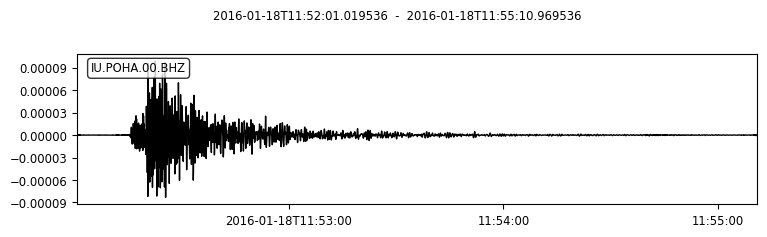

In [3]:
sample = quakes[3197]
_ = sample.plot()

### Convert all traces to same sampling rate

In [4]:
for trace in quakes:
    if trace.stats.sampling_rate != 40:
        trace.resample(40)
    trace.normalize()
        
set([x.stats.sampling_rate for x in quakes])

{40.0}

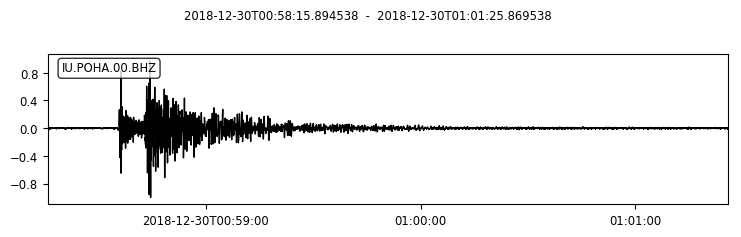

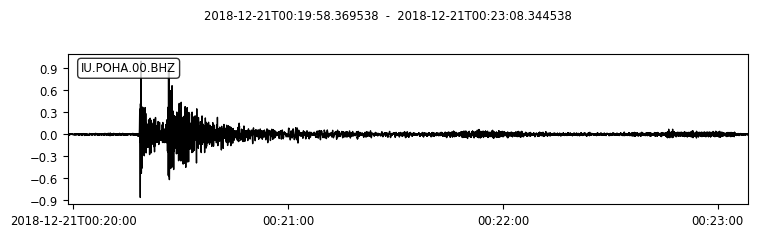

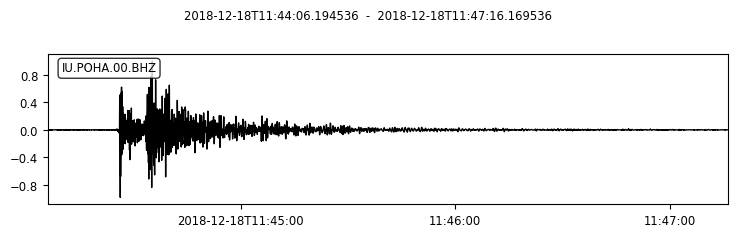

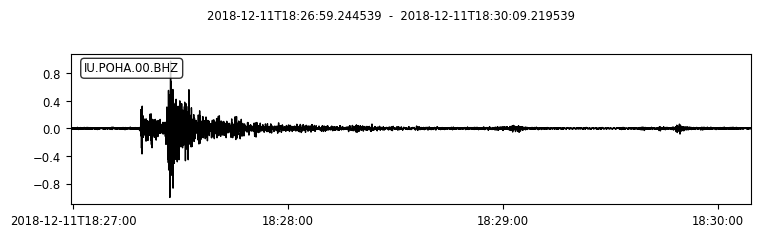

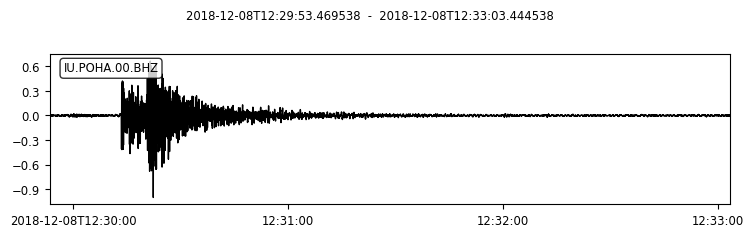

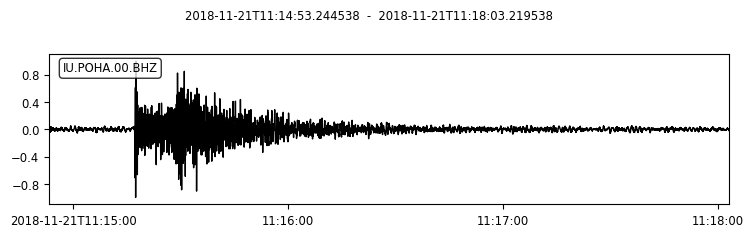

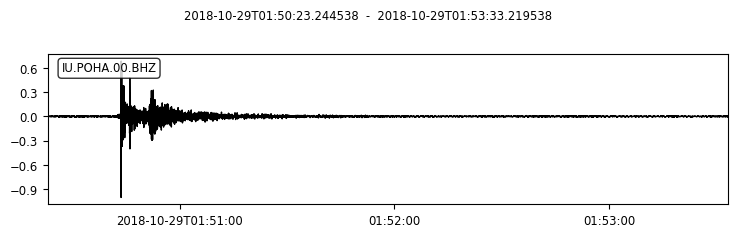

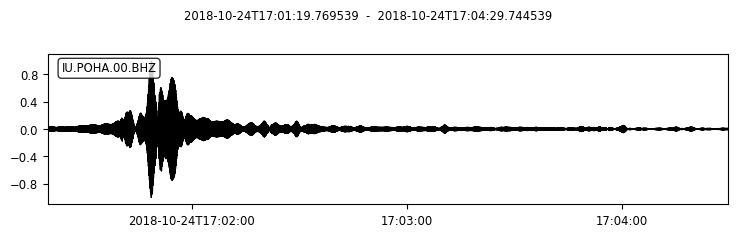

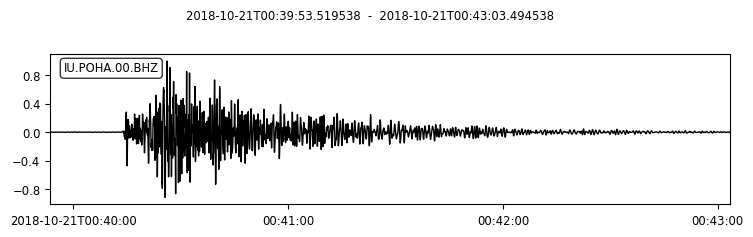

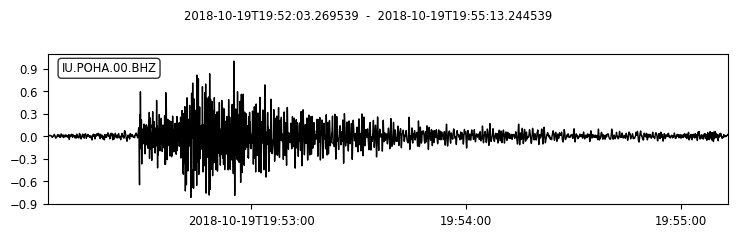

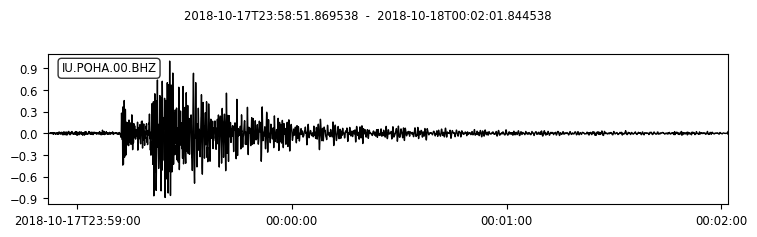

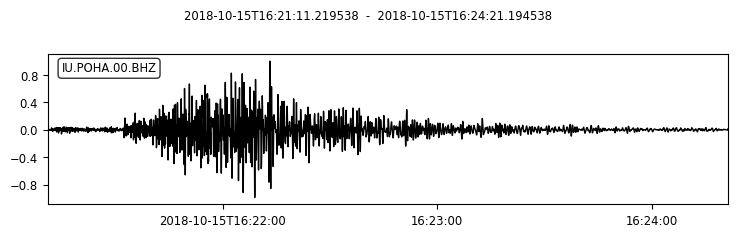

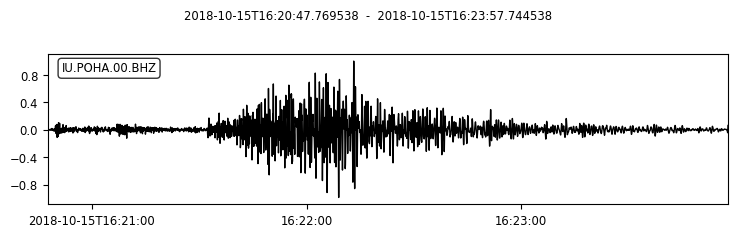

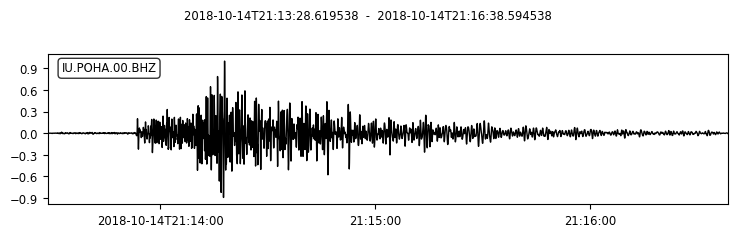

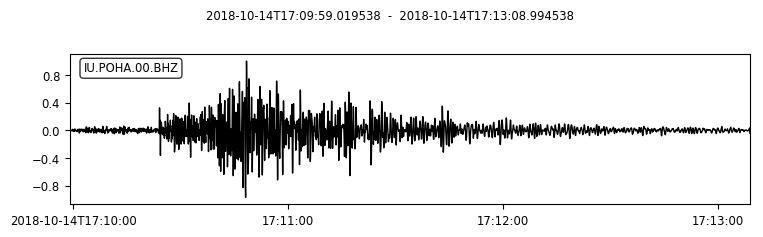

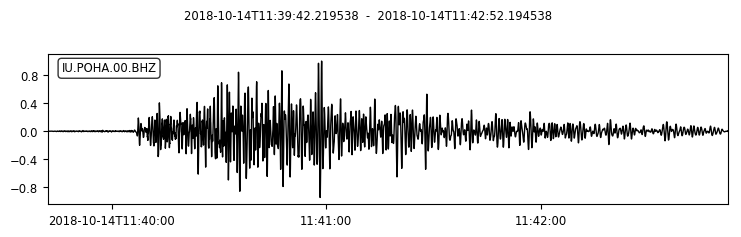

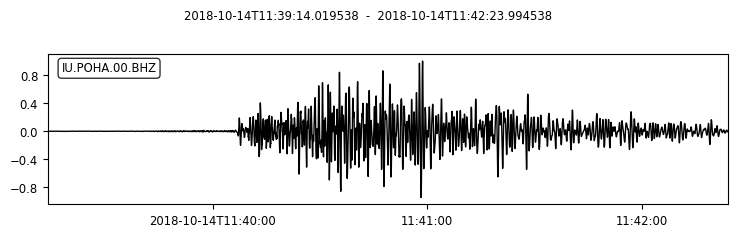

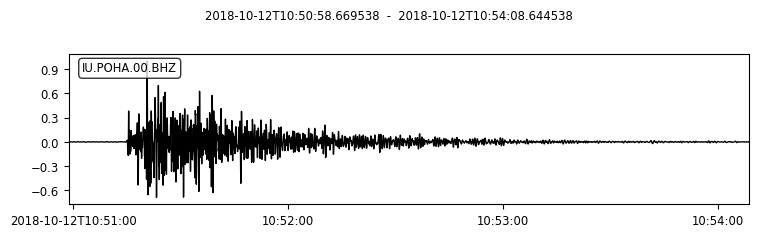

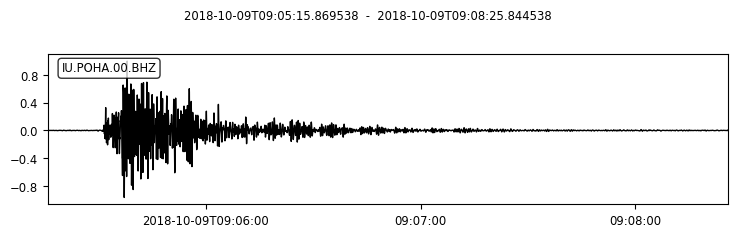

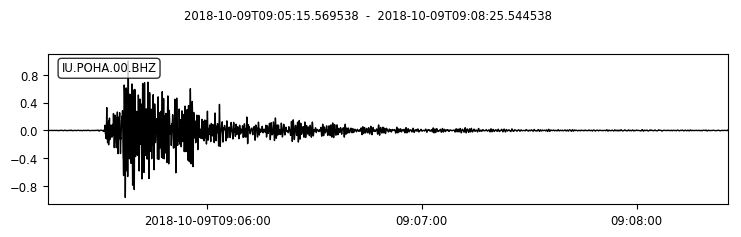

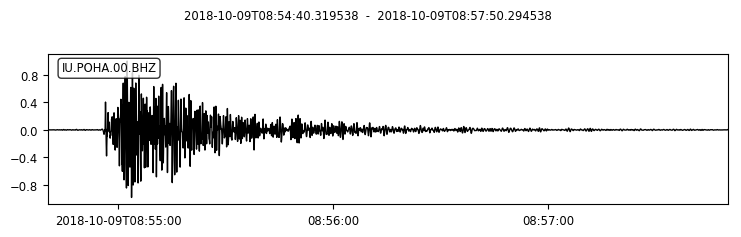

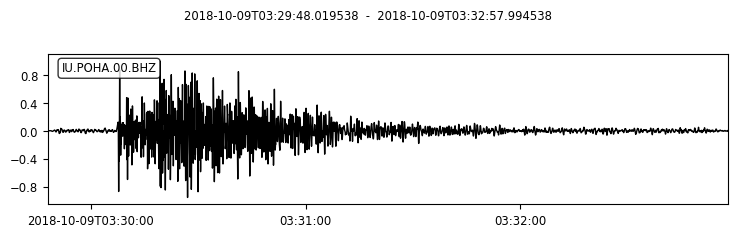

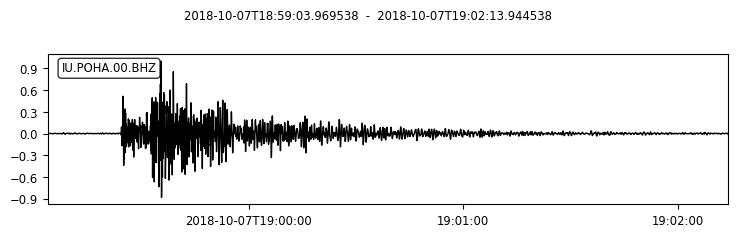

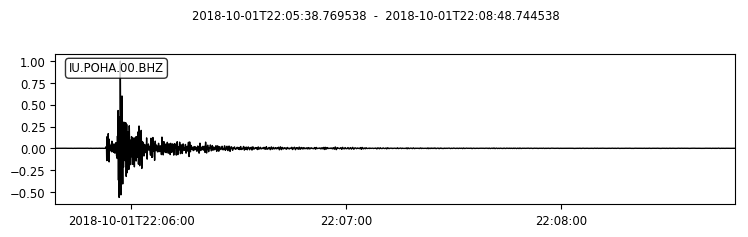

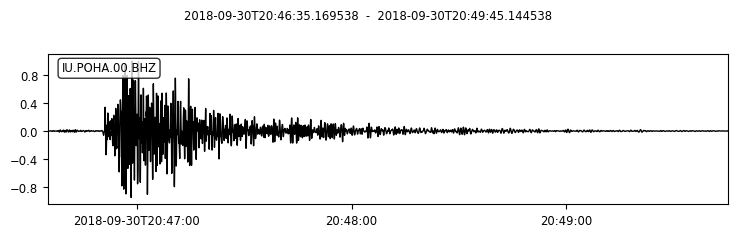

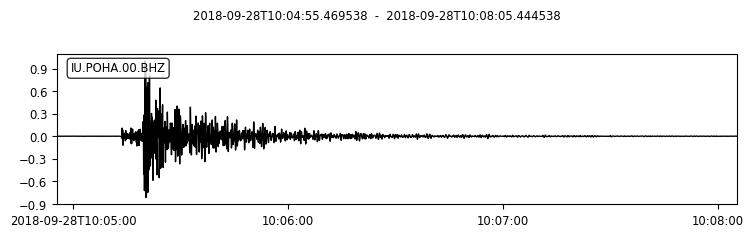

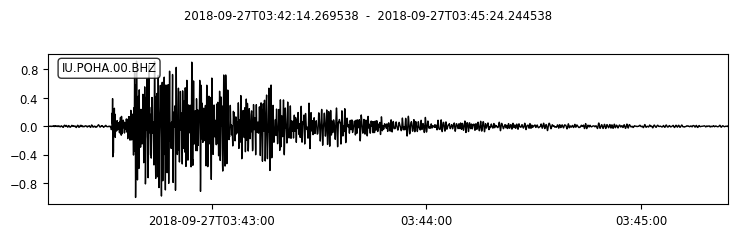

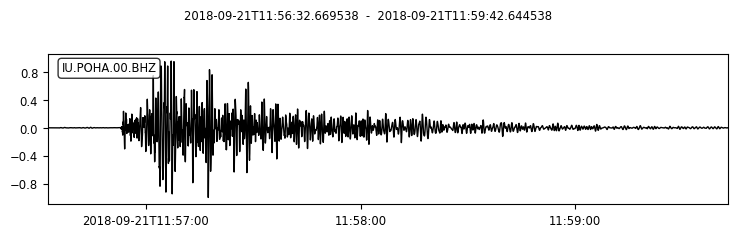

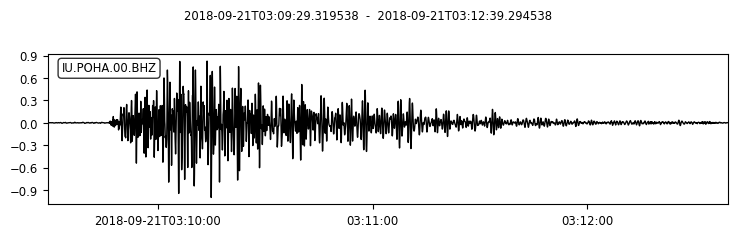

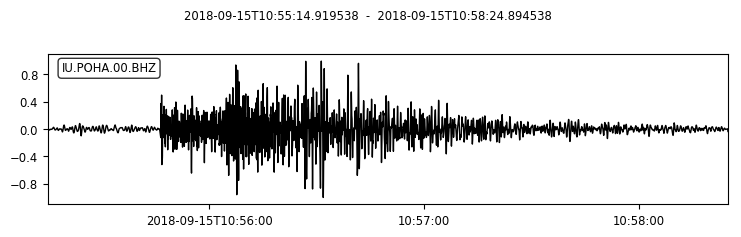

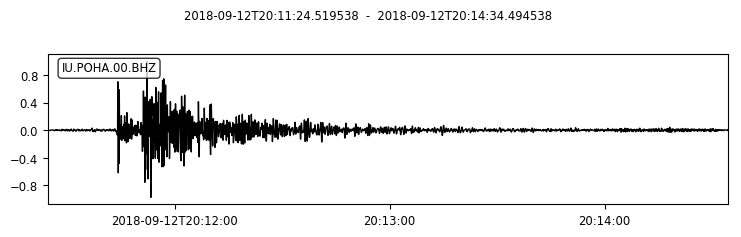

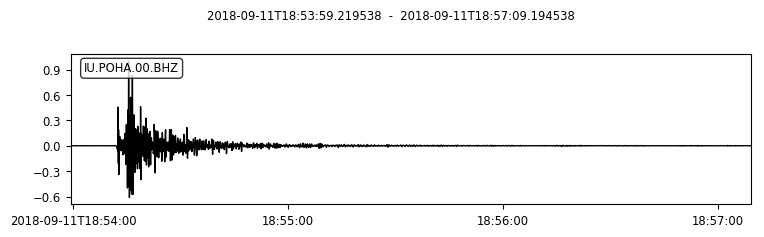

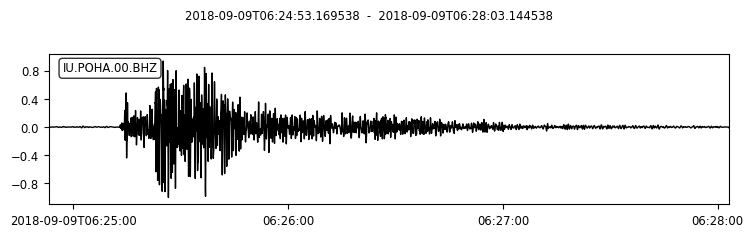

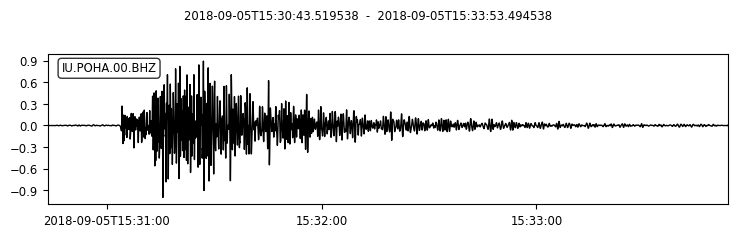

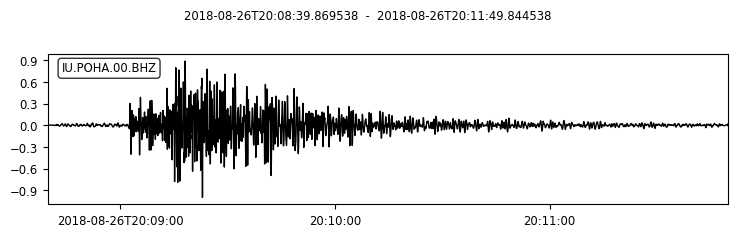

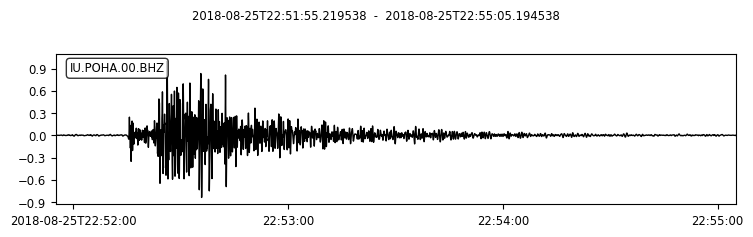

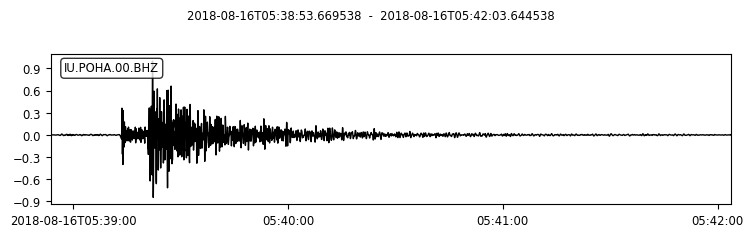

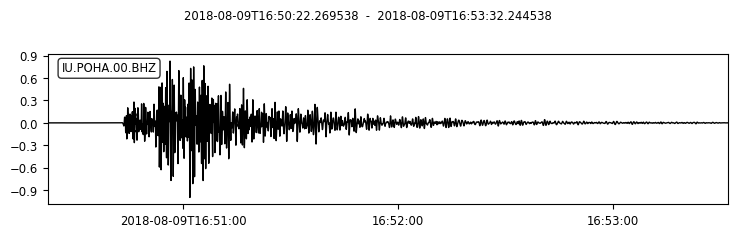

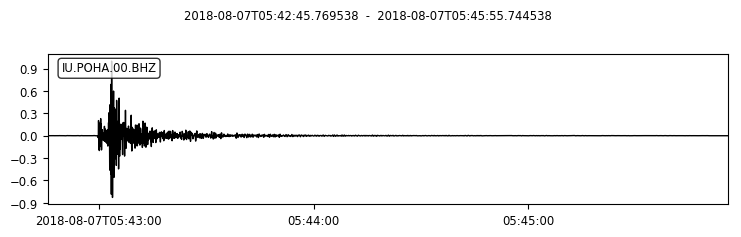

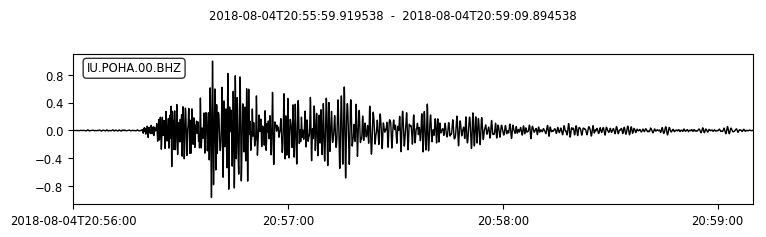

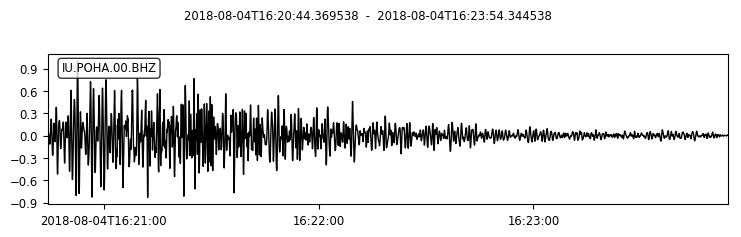

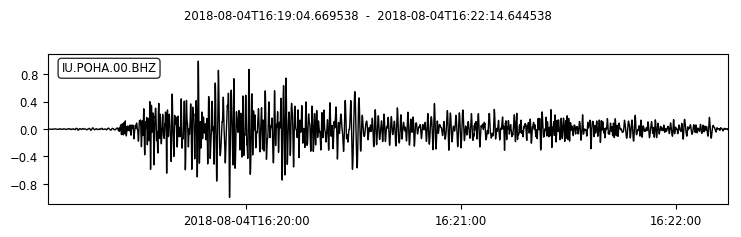

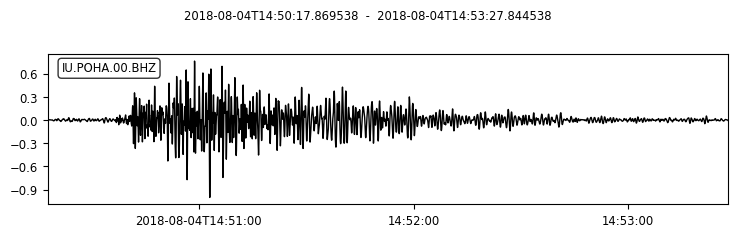

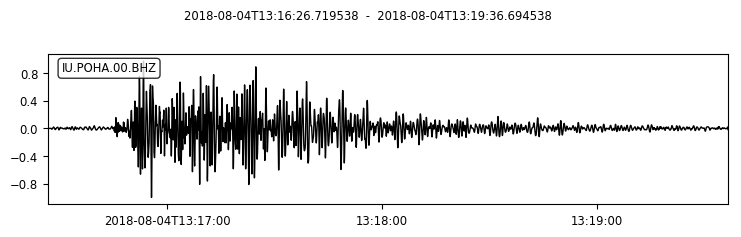

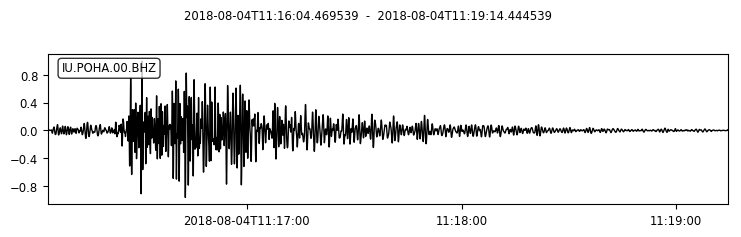

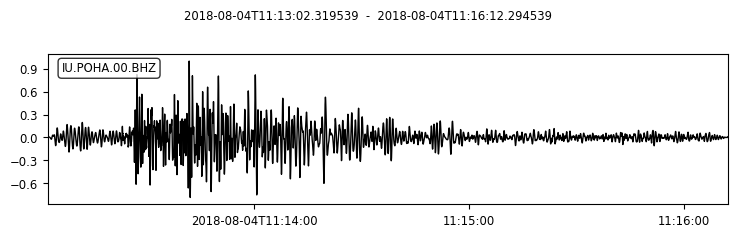

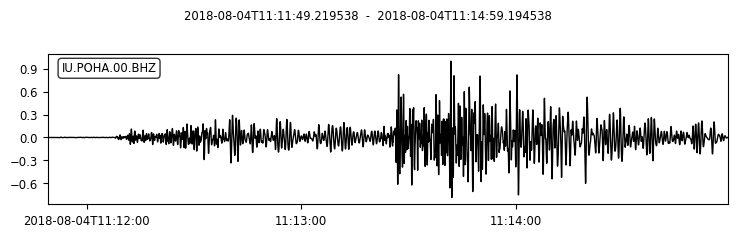

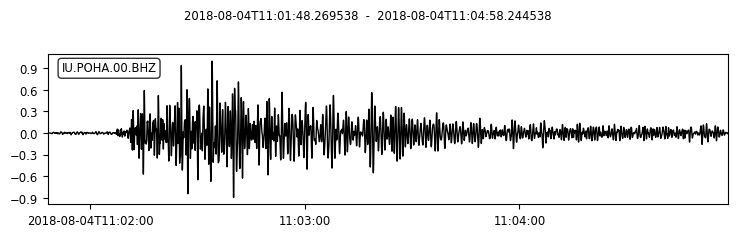

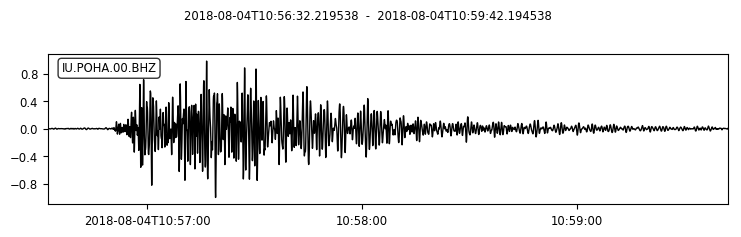

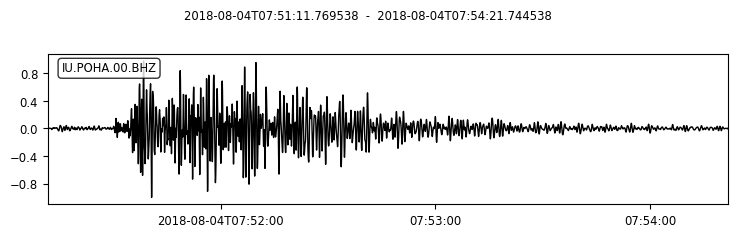

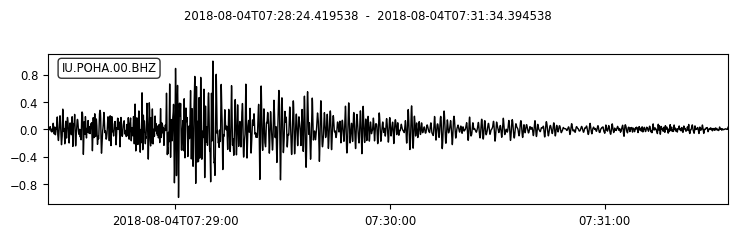

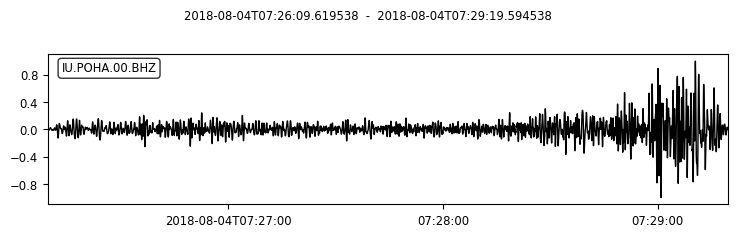

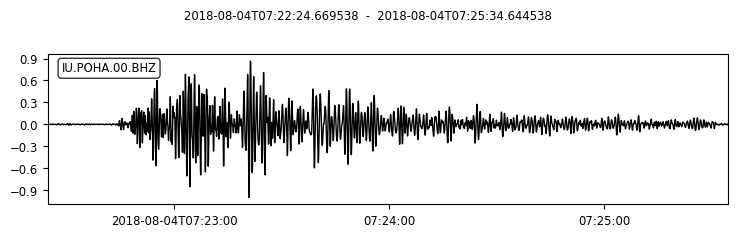

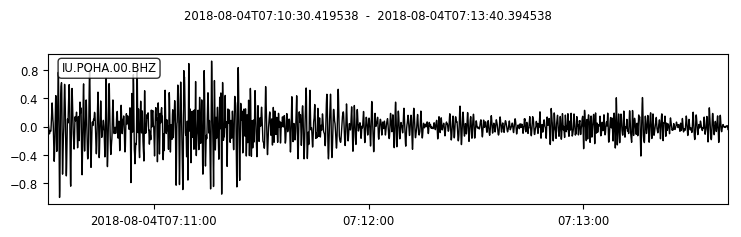

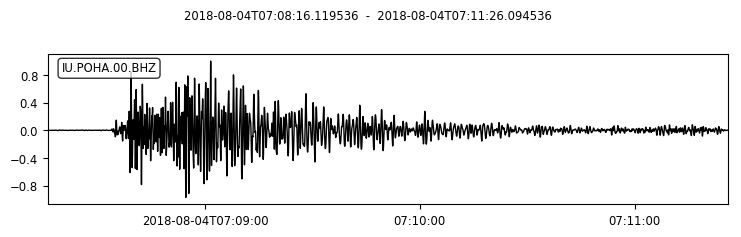

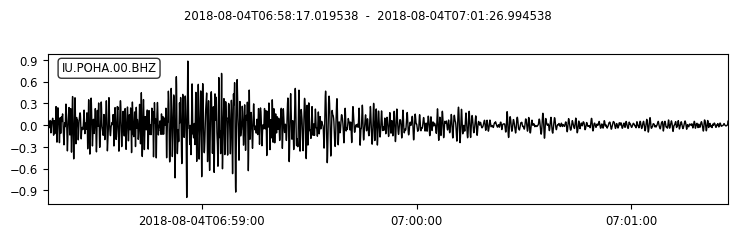

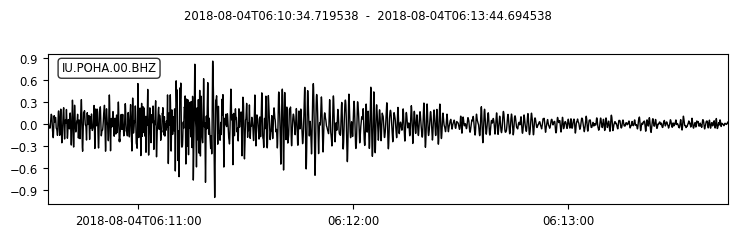

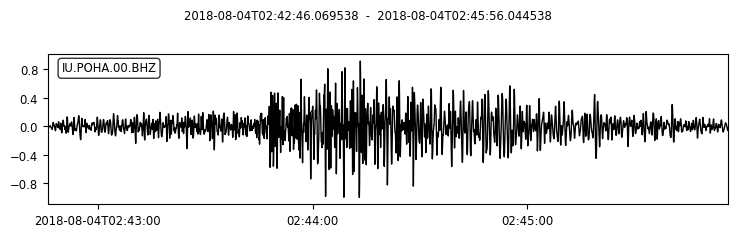

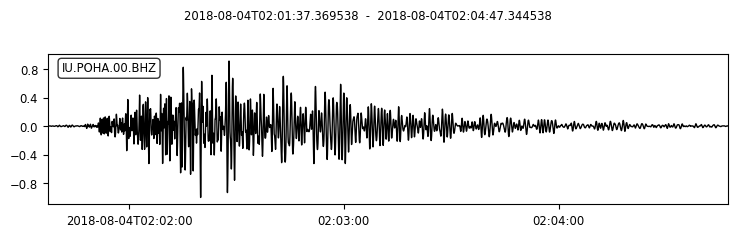

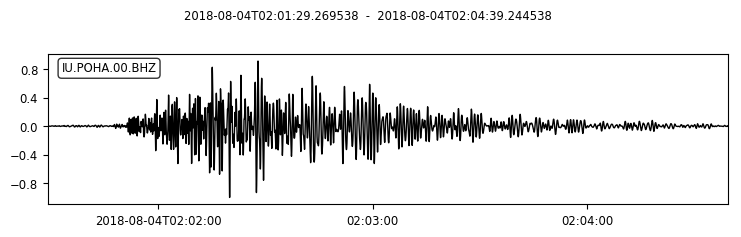

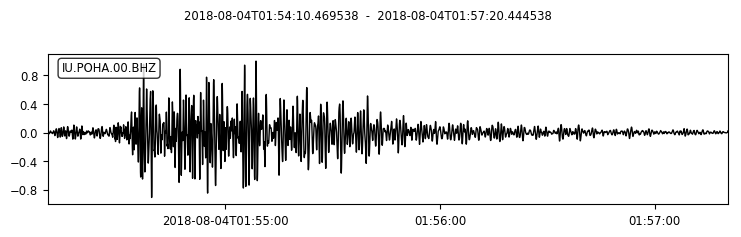

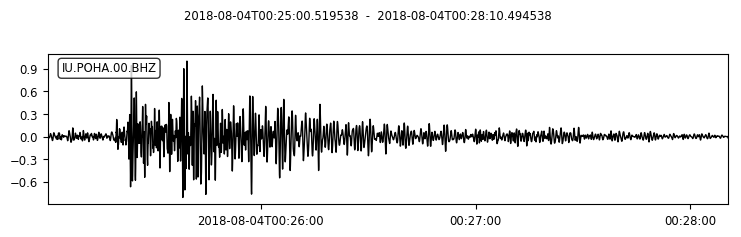

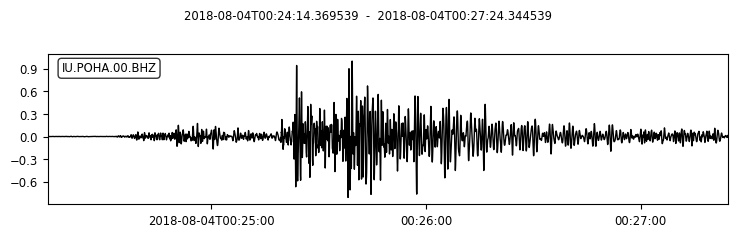

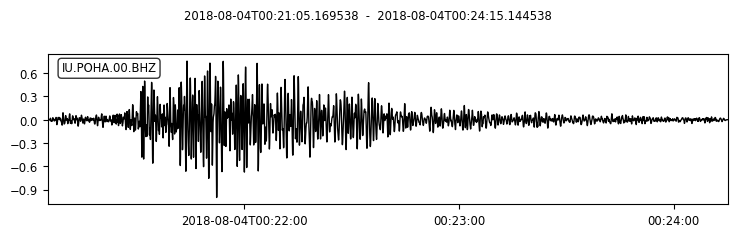

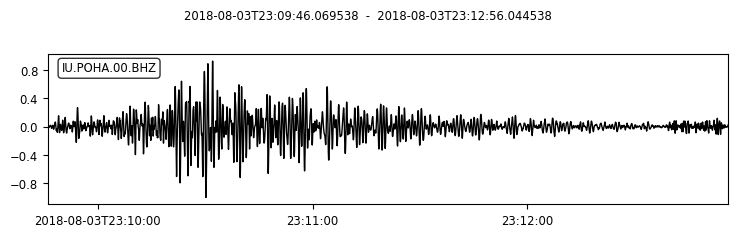

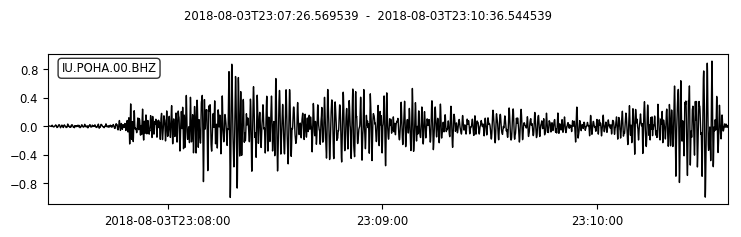

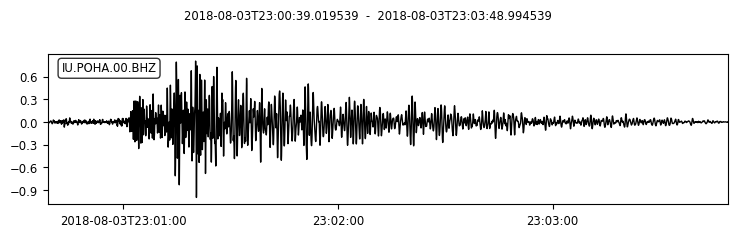

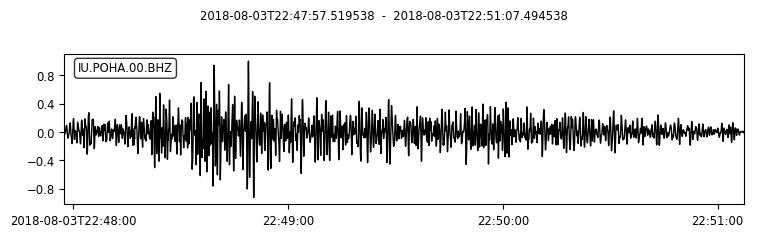

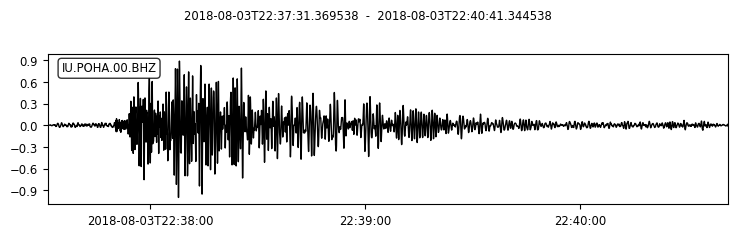

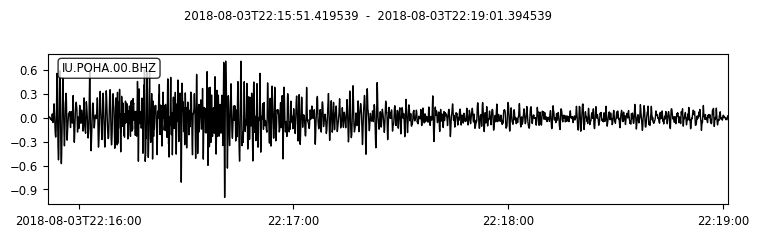

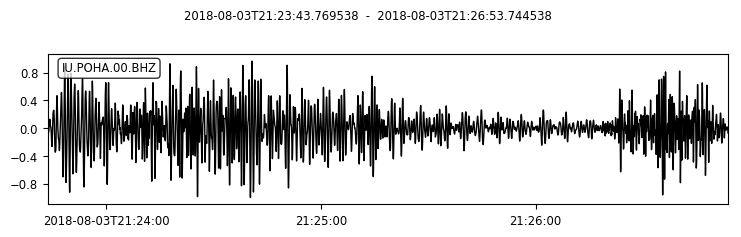

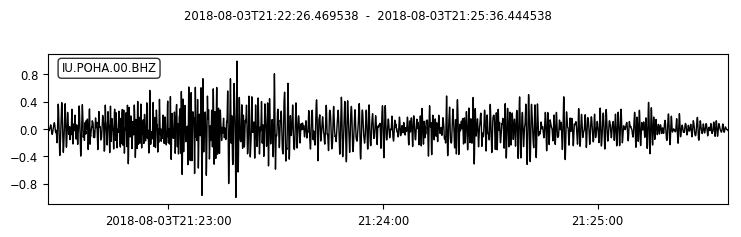

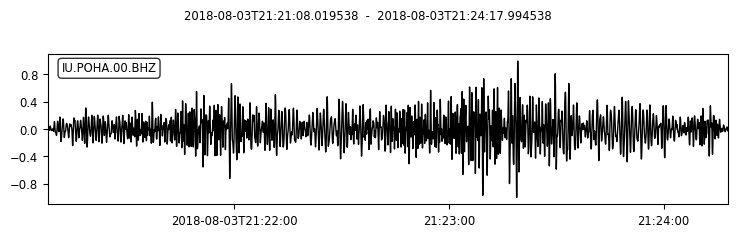

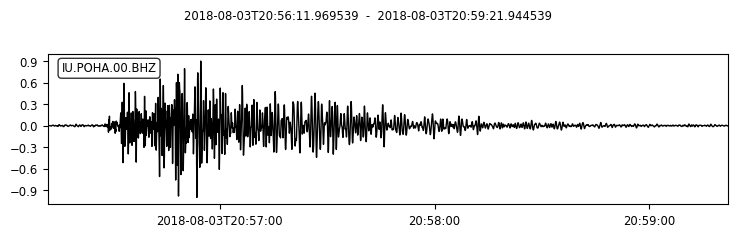

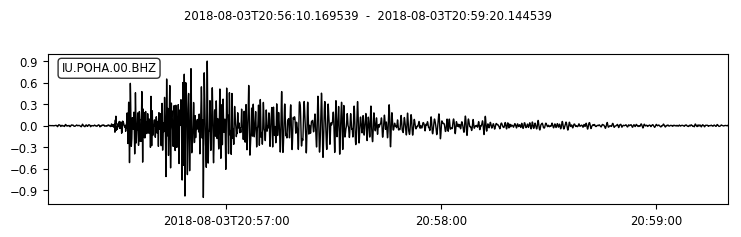

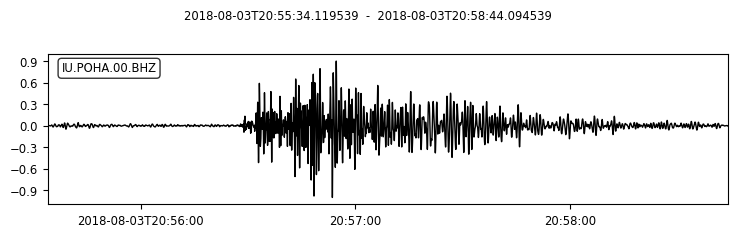

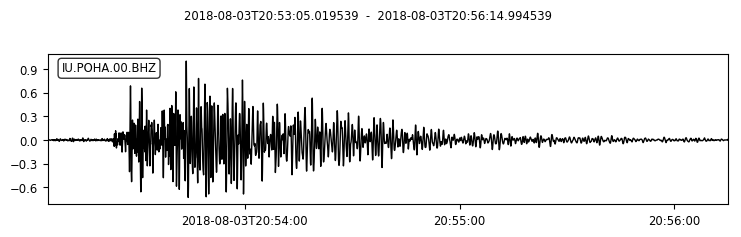

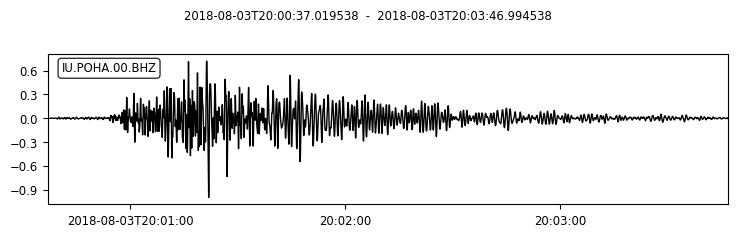

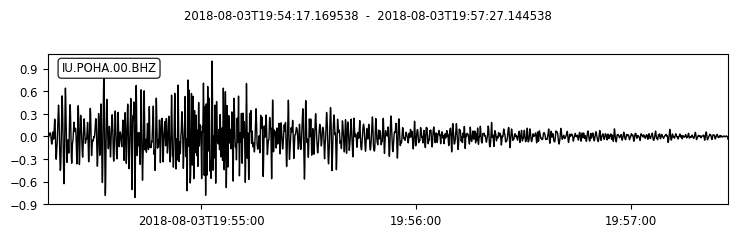

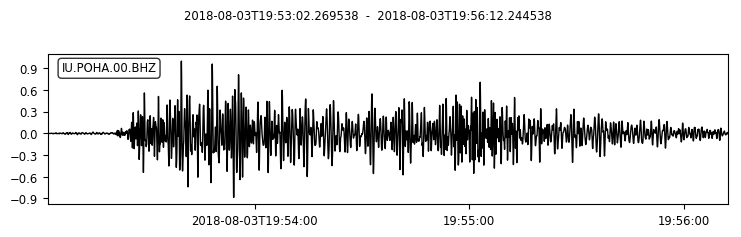

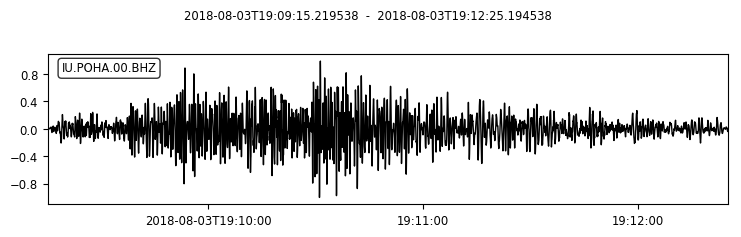

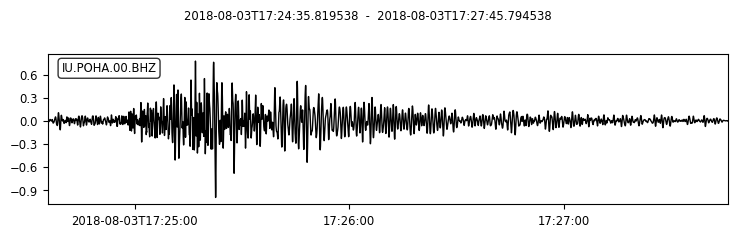

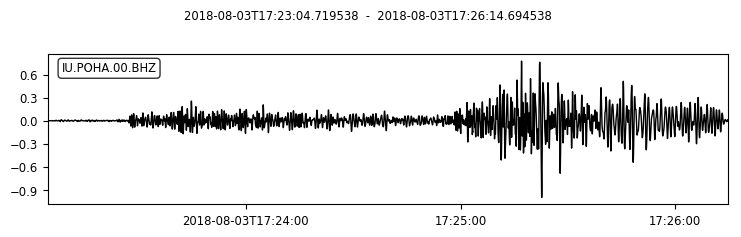

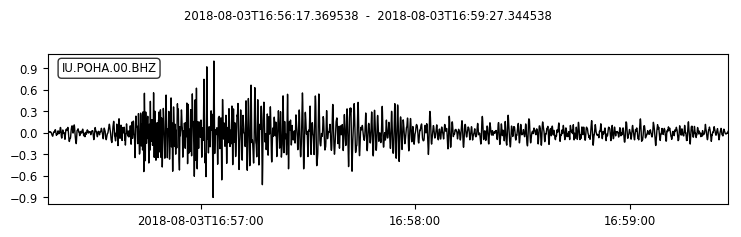

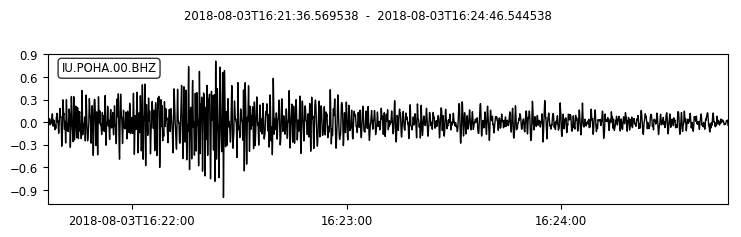

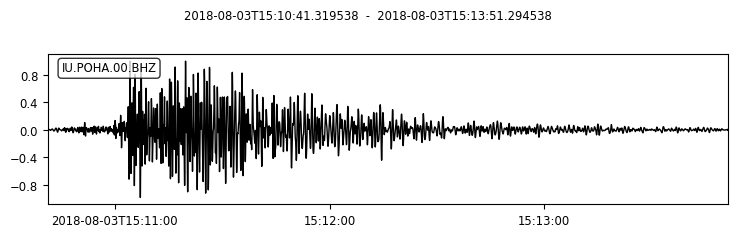

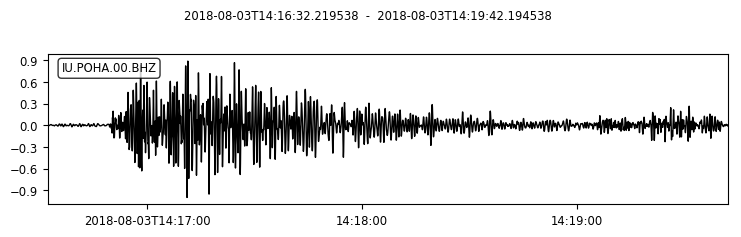

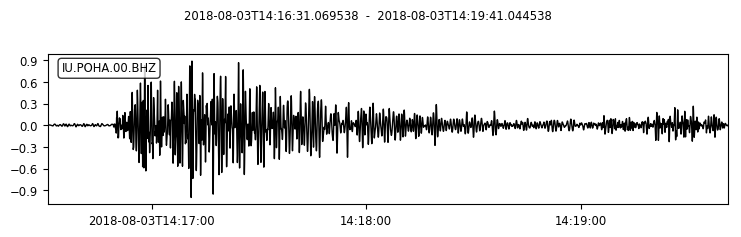

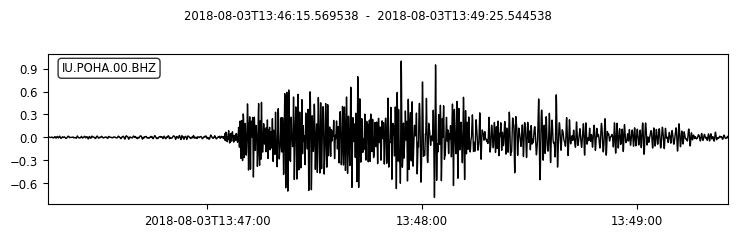

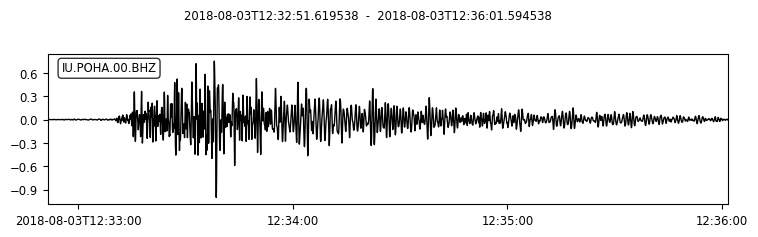

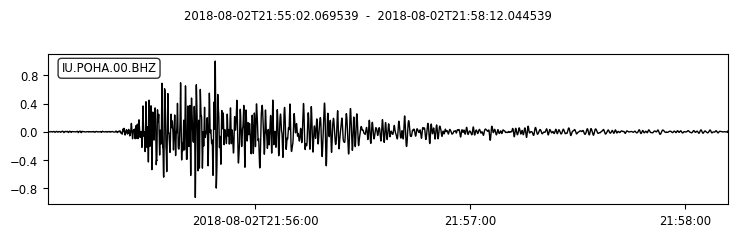

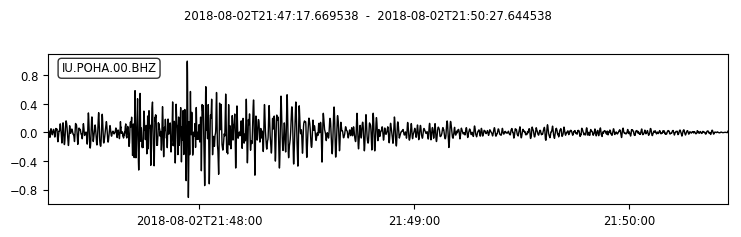

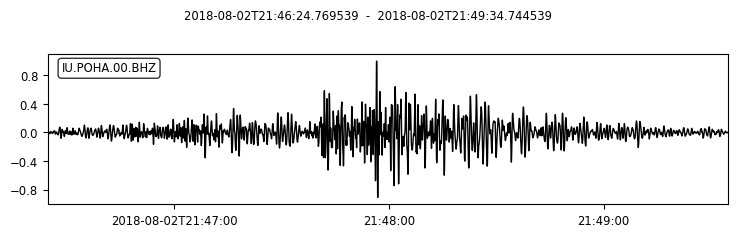

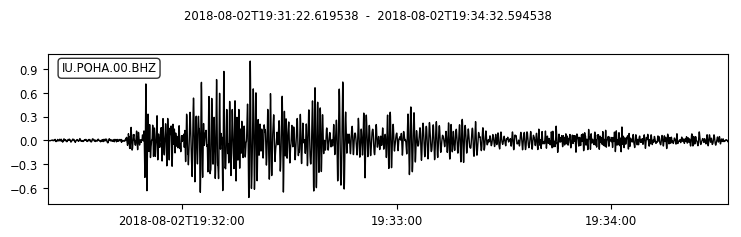

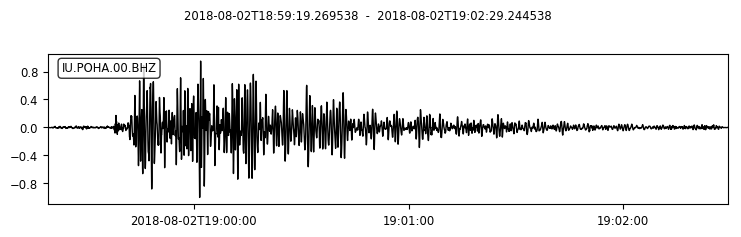

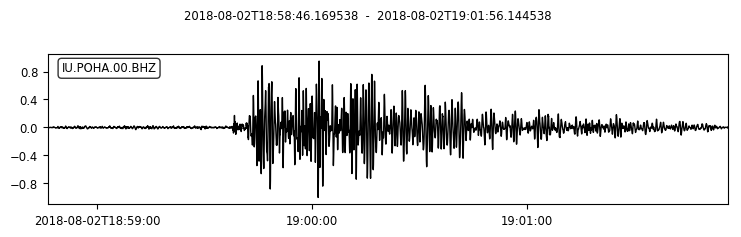

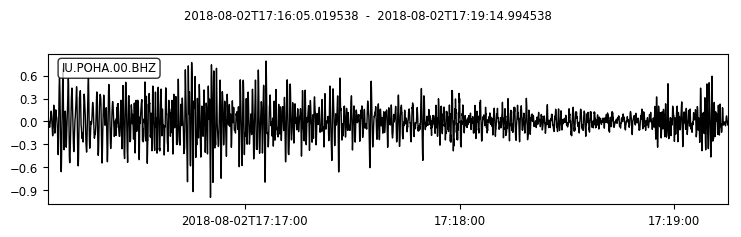

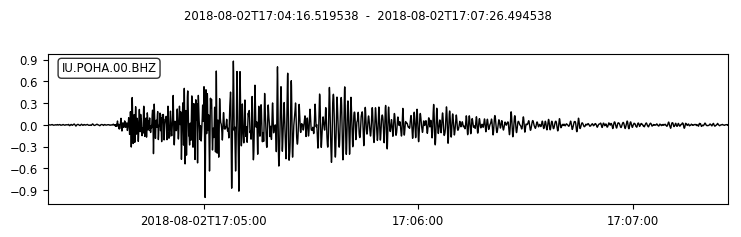

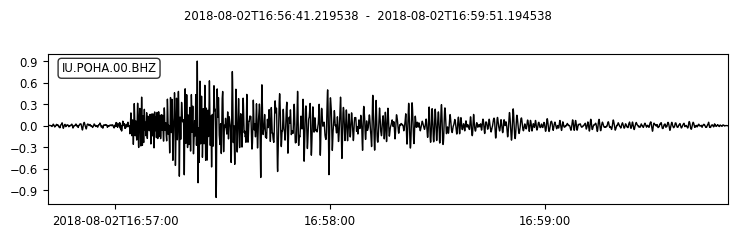

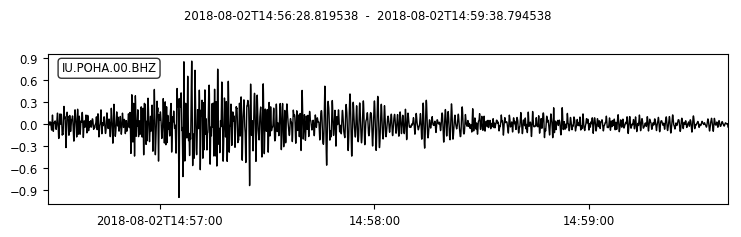

In [6]:
for trace in quakes[:100]:
    trace.plot()

### Pick P wave arrivals, and trim to 40 seconds
Plot the picks and spectrograms for sanity check

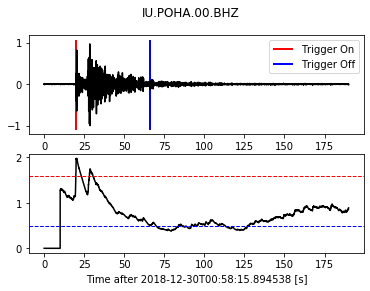

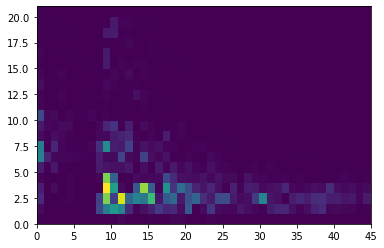

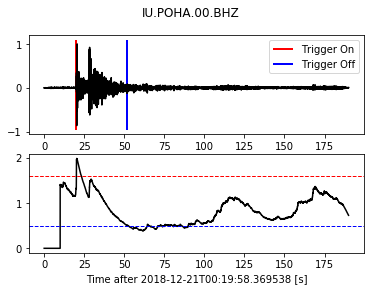

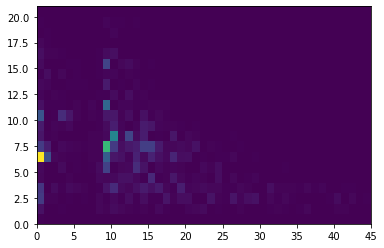

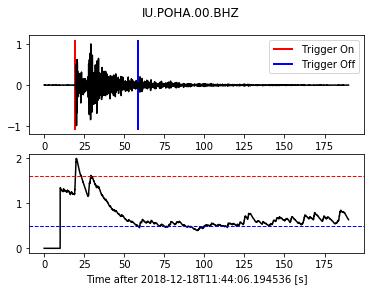

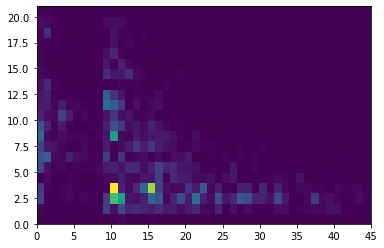

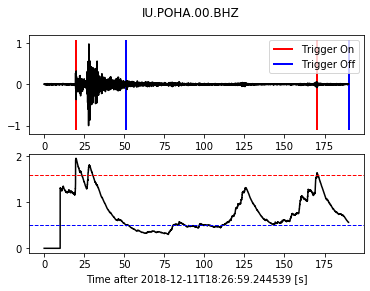

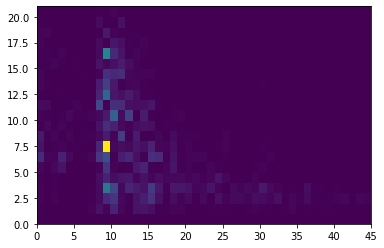

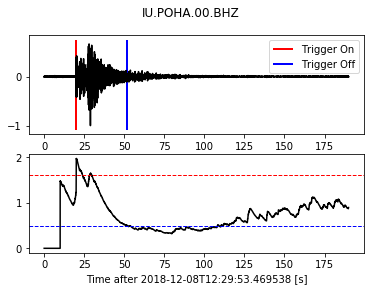

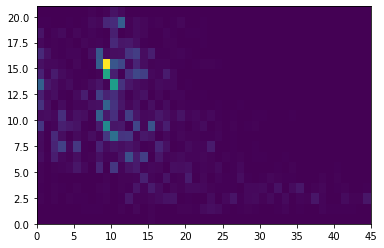

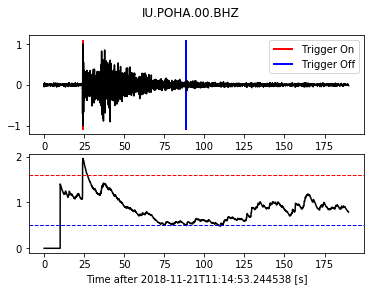

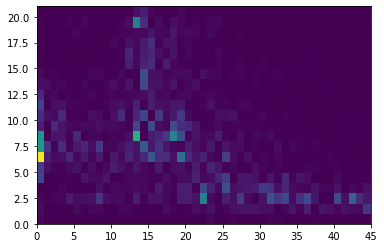

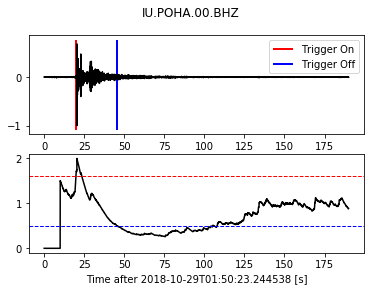

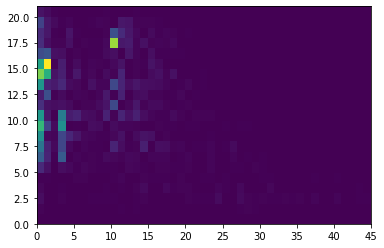

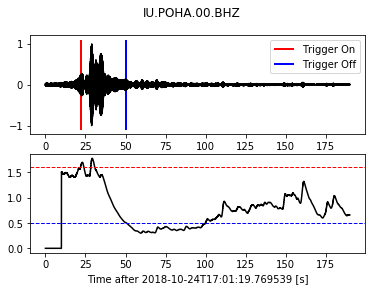

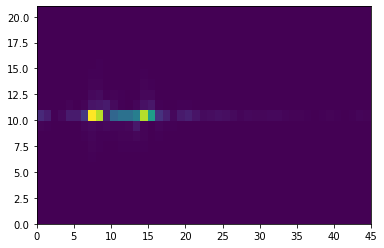

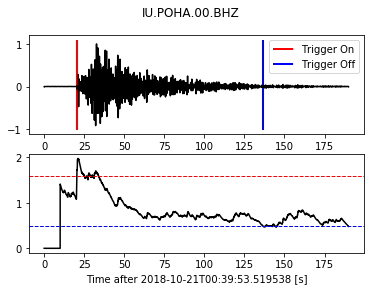

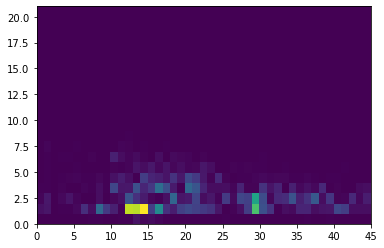

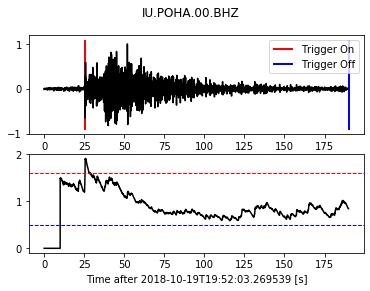

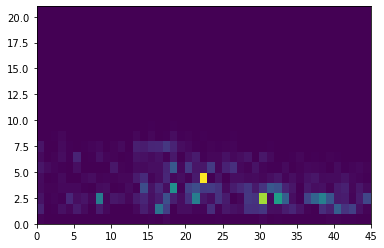

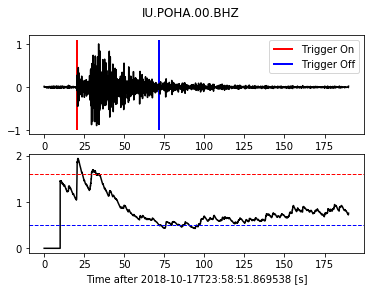

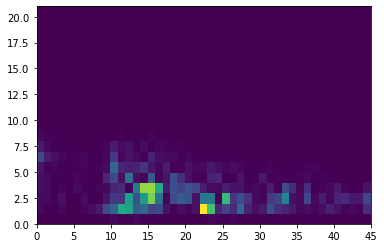

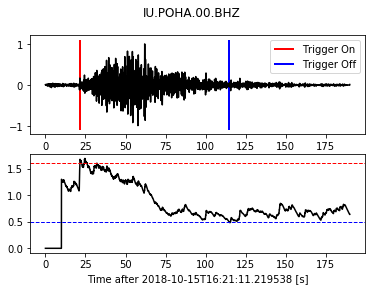

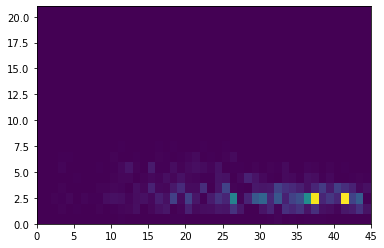

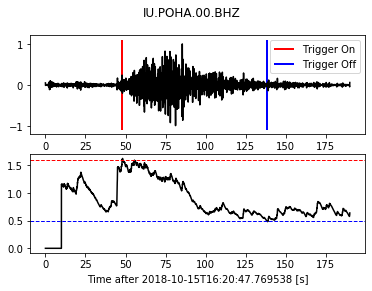

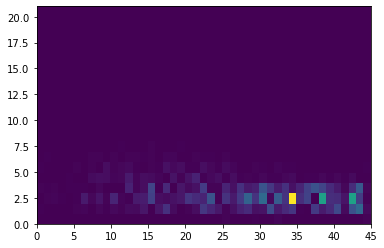

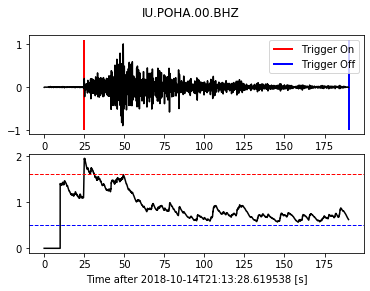

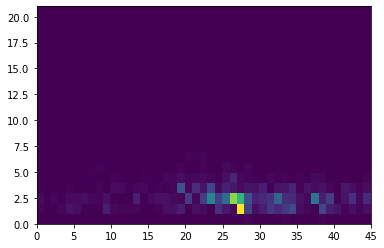

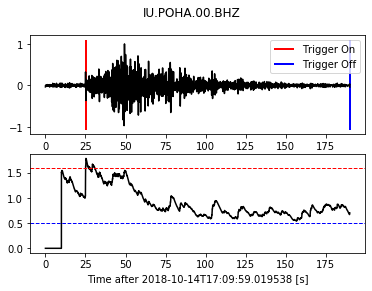

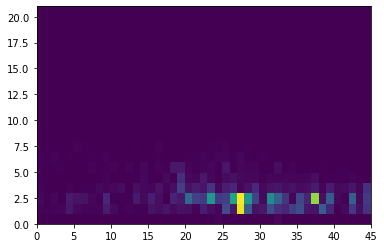

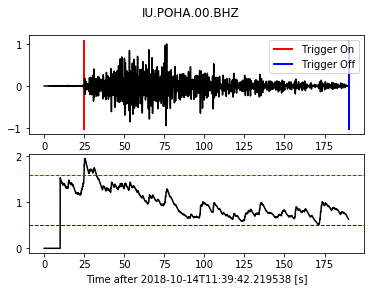

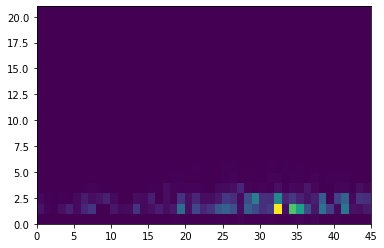

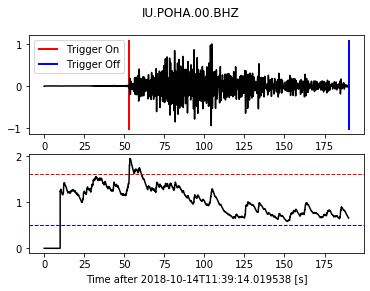

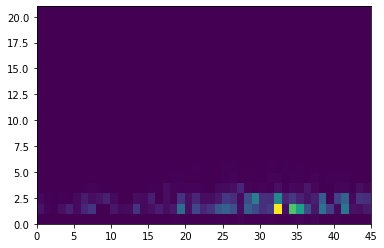

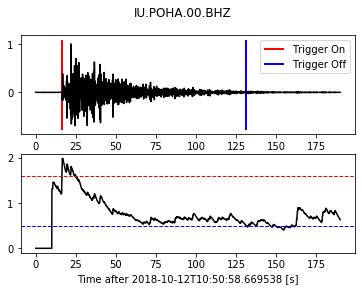

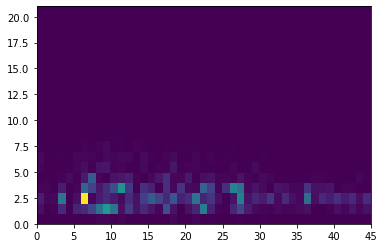

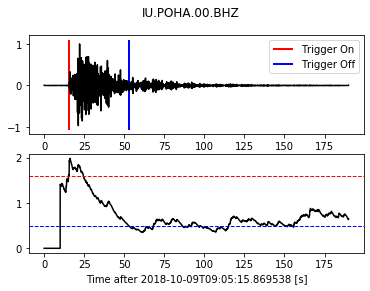

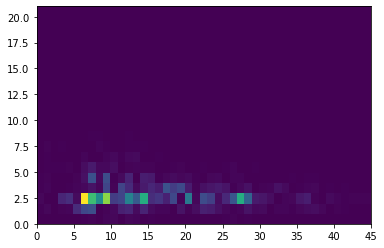

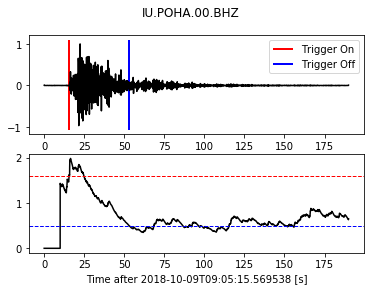

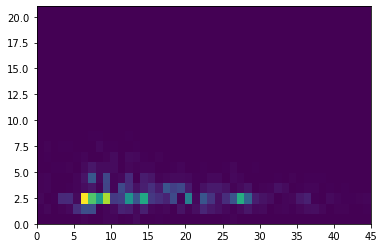

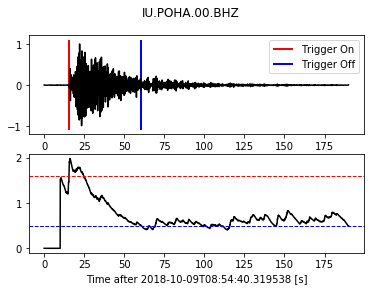

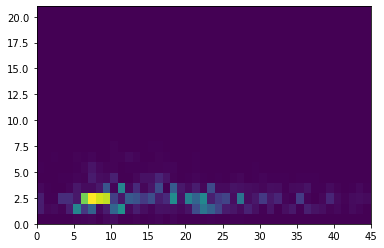

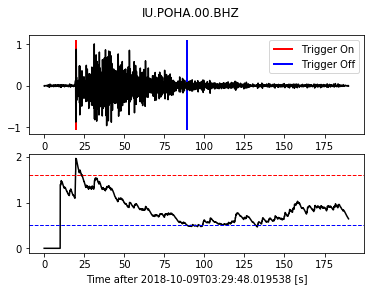

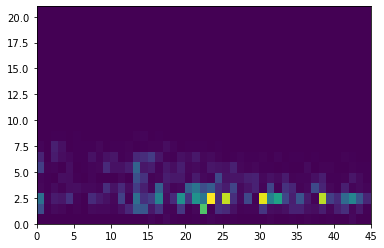

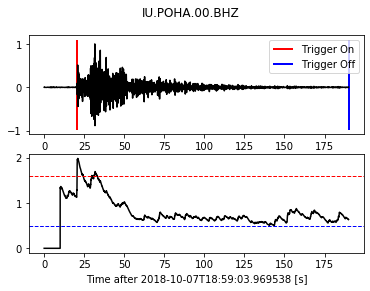

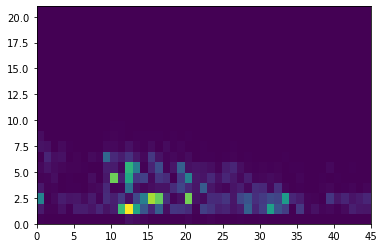

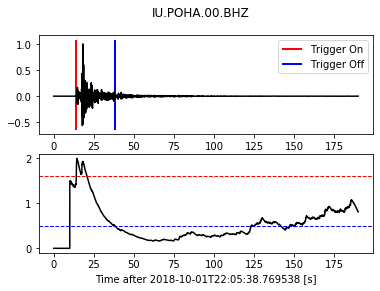

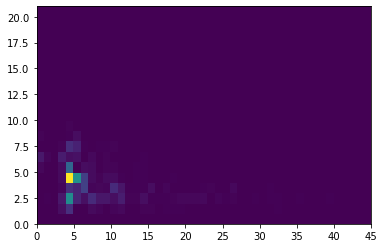

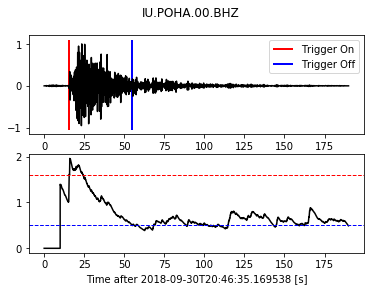

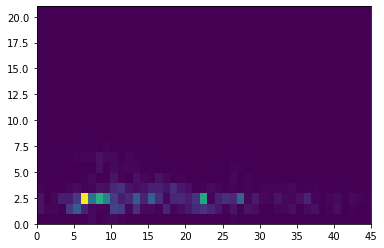

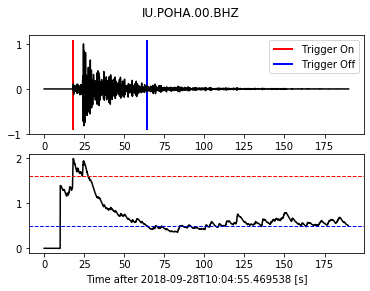

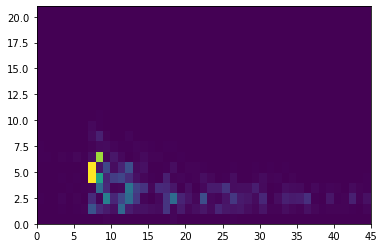

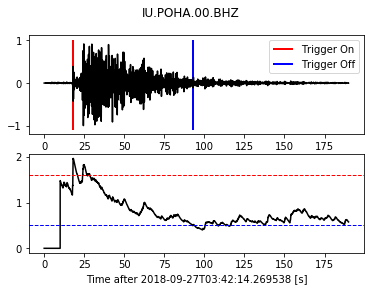

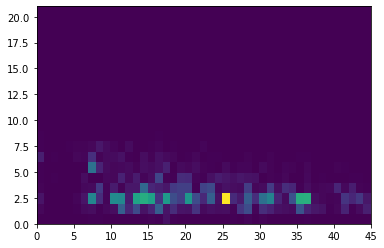

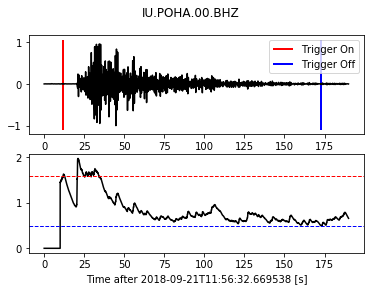

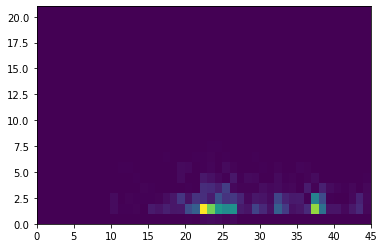

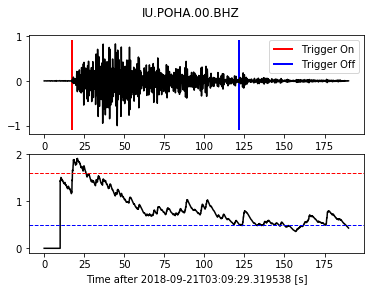

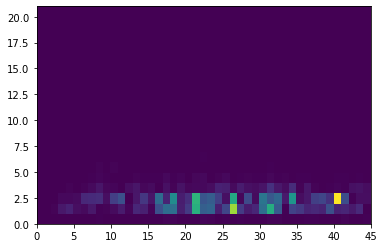

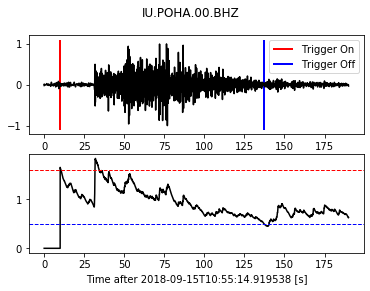

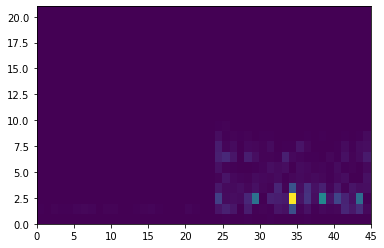

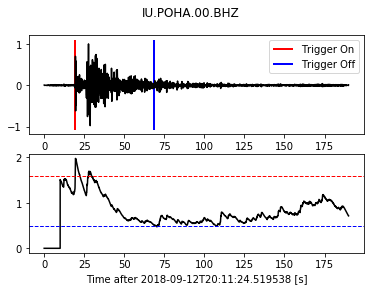

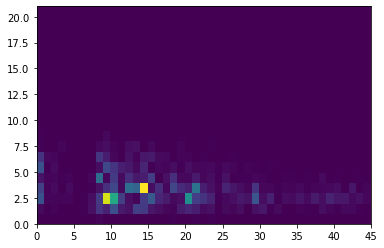

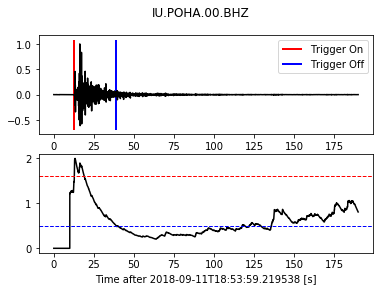

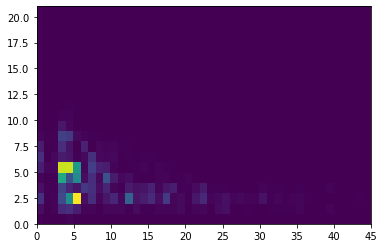

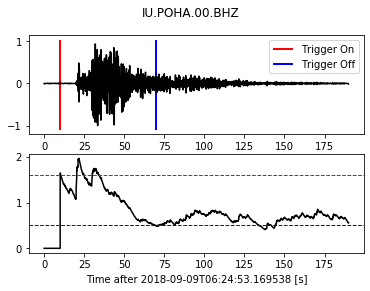

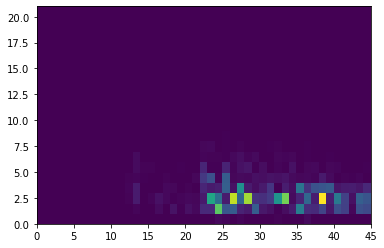

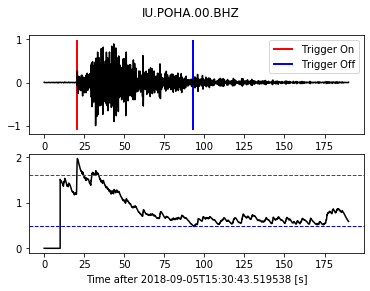

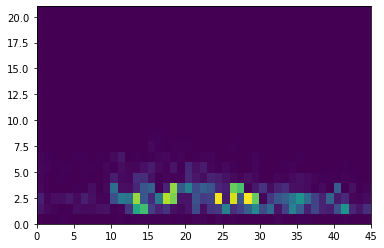

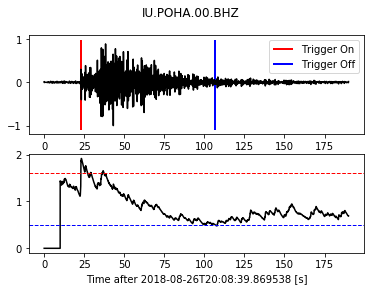

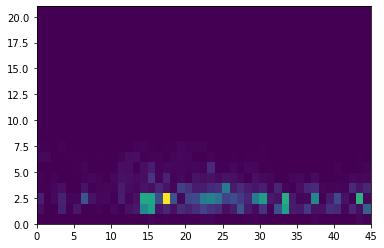

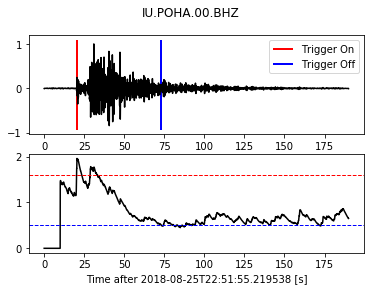

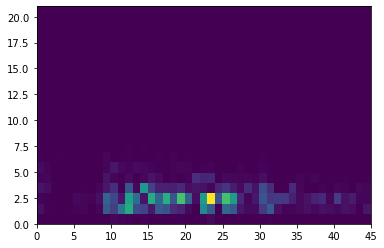

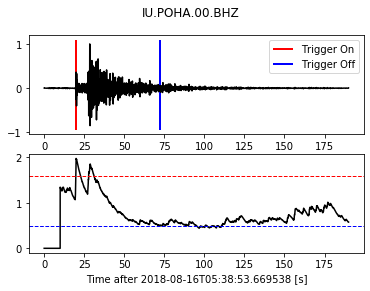

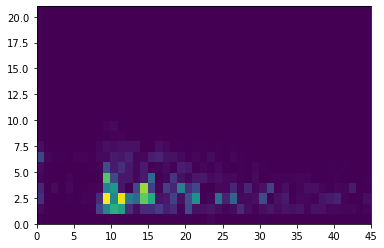

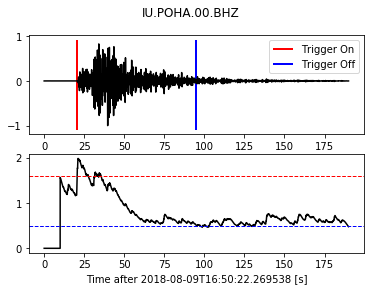

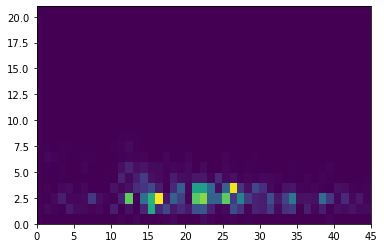

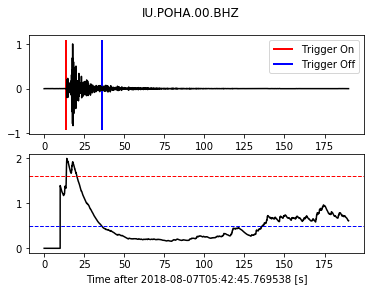

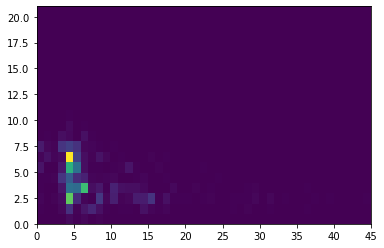

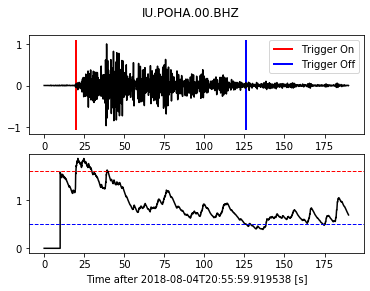

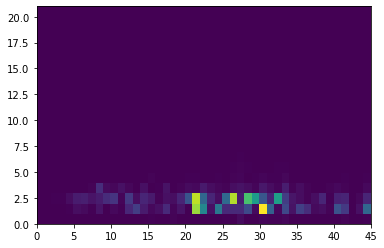

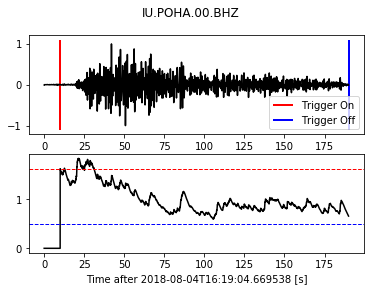

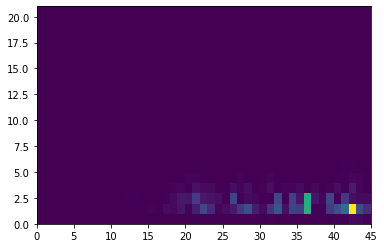

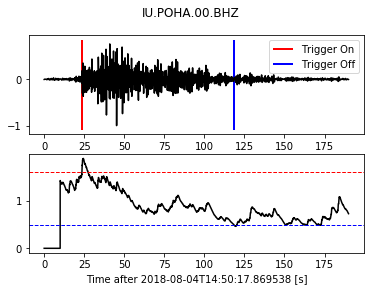

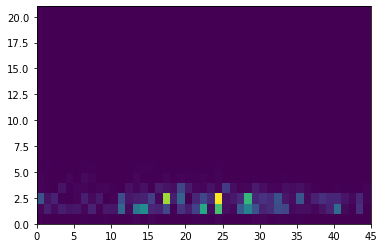

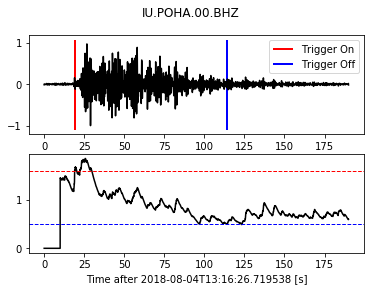

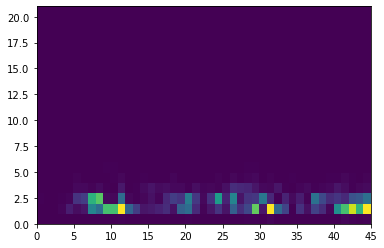

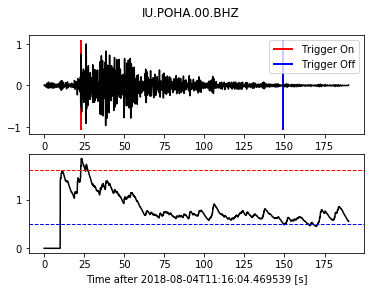

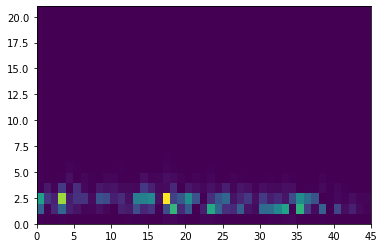

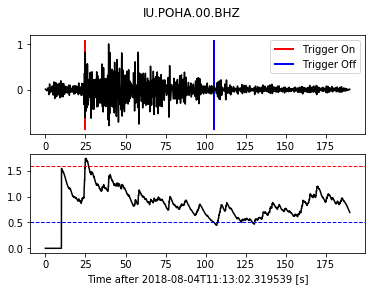

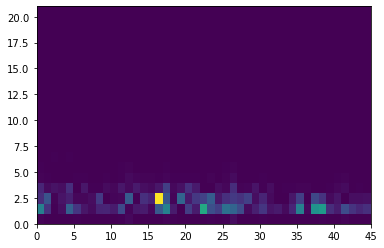

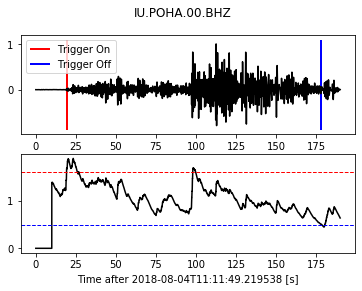

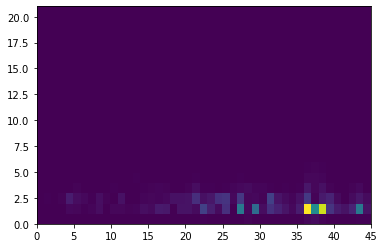

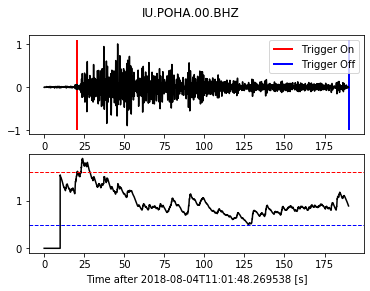

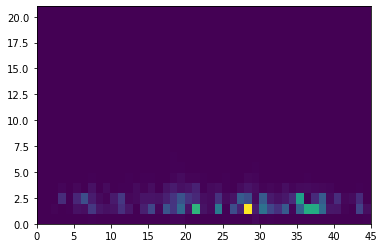

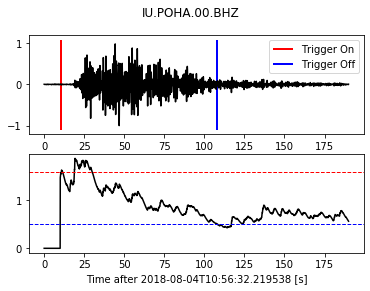

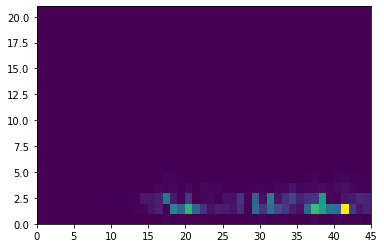

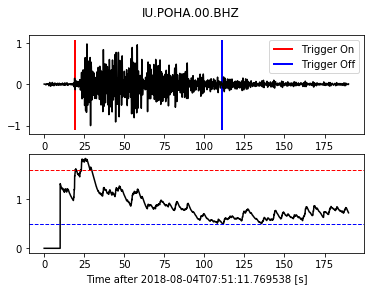

Number of traces kept: 2278
Number of traces skipped: 923


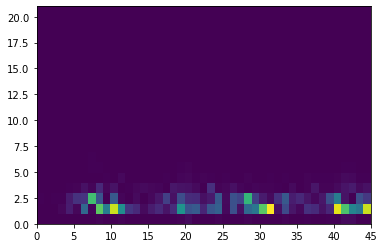

In [5]:
df = 40
trace_length = 40

raw_traces = []
i=0

for j,trace in enumerate(quakes):
    try:
        cft = recursive_sta_lta(trace.data, int(5 * df), int(10 * df))
        pick = trigger_onset(cft, 1.6, 0.5)[0][0]
        trimmed_waveform = trace[pick:pick+trace_length*df]
        raw_traces.append(trimmed_waveform)
        """if j < 50:
            plot_trigger(trace, cft, 1.6, 0.5)
            _, _, Sxx = spectrogram(trimmed_waveform, nperseg=int(df), scaling='spectrum')
            plt.pcolormesh(Sxx)
            #plt.plot(trimmed_waveform)
        """
    except:
        #plot_trigger(trace, cft, 1.6, 0.5)
        i=i+1

print("Number of traces kept: {}".format(len(raw_traces)))
print("Number of traces skipped: {}".format(i))

## Create spectrograms
Only create spectrograms if a full length is available - some waveforms dont get a pick early enough to get the entire 40 or so seconds of data afterwards

2228


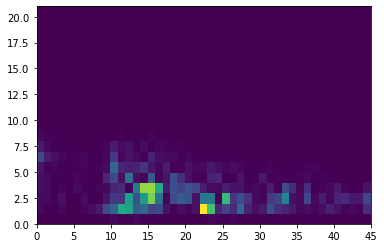

In [6]:
spectrograms = []

for waveform in raw_traces:
    if len(waveform) == trace_length*df:
        _, _, Sxx = spectrogram(waveform, nperseg=int(df), scaling='spectrum')
        spectrograms.append(Sxx)
    
plt.pcolormesh(spectrograms[10])
print(len(spectrograms))

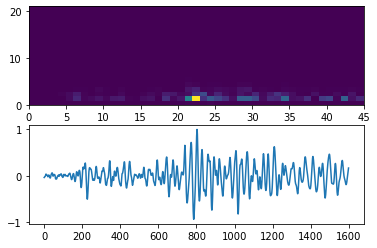

In [7]:
i=350

f, (ax1,ax2) = plt.subplots(2,1)

ax1.pcolormesh(spectrograms[i])
ax2.plot(raw_traces[i])

## Save spectrograms

### Concatenate all spectrograms

In [8]:
spectrograms = np.dstack(spectrograms)

In [15]:
spectrograms.shape

(21, 45, 2228)

In [32]:
np.save('hawaii_2016_2018_mag3_spectrograms.npy', spectrograms)


In [35]:
specs = np.load('hawaii_2016_2018_mag3_spectrograms.npy')


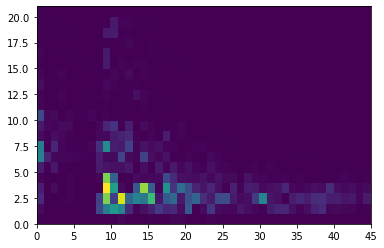

In [44]:
plt.pcolormesh(specs[:,:,0])

In [37]:
specs.shape

(21, 45, 2228)

In [42]:
s = specs.reshape(2228,21,45)

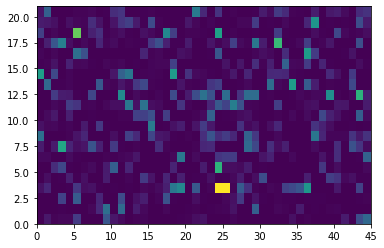

In [45]:
plt.pcolormesh(s[0,:,:])

In [ ]:
spectrigr